In [2]:
from pymongo import MongoClient
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import operator
from scipy.spatial import distance
from Levenshtein import *
import re
%matplotlib inline

In [3]:
#Preprocessing functions:



def stringConditionProcess(group, method = "first"):
    result = []
    for timeSeries in group:
        conditions = seriesContains(timeSeries, method)
        result.append(timeSeries[conditions])
    return result

def getUsersPolarities(collectionName):
    collection = MongoClient("localhost", 27017)['idea'][collectionName]
    usersPolarties = {}
    for tweet in collection.find():
        userID = tweet["user"]["id"]
        if tweet["polarity"] == "positive":
            polarity = 1
        elif tweet["polarity"] == "negative":
            polarity = -1
        else:
            polarity = 0
   
            
        date = tweet["created_at"]
        text = tweet['text']

        if userID not in usersPolarties:
            usersPolarties[userID] = {}
        if date not in usersPolarties[userID]:
            usersPolarties[userID][date] = {}
        usersPolarties[userID][date]['text'] = text
        usersPolarties[userID][date]['polarity'] =  polarity


    return usersPolarties


def timeSeriesTransform(usersEmotions):
    for userID in usersEmotions:
        usersEmotions[userID] = pd.DataFrame.from_dict(usersEmotions[userID], orient='index').fillna(0)
        usersEmotions[userID]['dt'] = np.zeros(usersEmotions[userID].shape[0],dtype=float)
        usersEmotions[userID].loc[:-1,'dt'] = (usersEmotions[userID].index[1:].values - usersEmotions[userID].index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return list(usersEmotions.values())


def disambiguate(timeSeries):
    conditions = np.logical_not(timeSeries['ambiguous'].values)
    timeSeries = timeSeries[conditions]
    timeSeries['dt'] = np.zeros(timeSeries.shape[0],dtype=float)
    timeSeries.loc[:-1,'dt'] = (timeSeries.index[1:].values - timeSeries.index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return timeSeries
        
def invalid_removal(data):
    data = np.array(data)
    return data[np.isfinite(data)]
    
def reject_outliers(data, m=2):
    data = np.array(data)
    data = data[np.isfinite(data)]
    return data[abs(data - np.mean(data)) < m * np.std(data)]        
        
        
    

In [4]:
#computational functions

def negative_counter(timeSeries):
    return timeSeries["polarity"].values == -1
def positive_counter(timeSeries):
    return timeSeries["polarity"].values == 1

def comboTracker(timeSeries, attribute= "polarity"):
    array = timeSeries[attribute]
    starter = array[0]
    combo = 1
    result = []
    for cursor in array[1:]:
        if starter == cursor:
            combo += 1
        else:
            if combo > 1:
                result.append((starter, combo))
            starter = cursor
            combo = 1
    if combo > 1:
         result.append((starter, combo))
    return result





def seriesContains(timeSeries,method ="first"):
    if method == "first":
        match_function = np.vectorize(firstPronuonDetect)
    elif method == "second":
        match_function = np.vectorize(secondPronuonDetect)
    elif method == "third":
            match_function = np.vectorize(thirdPronuonDetect)


    return match_function(timeSeries["text"].str.lower().str.split().values)
    


def thirdPronuonDetect(words, matcher=re.compile("@[a-z]+")):
    for word in words:
        if word == "@":
            continue
        elif matcher.search(word):
            return True
    return False
    
    
def secondPronuonDetect(words, matchers=["you"]):
    for matcher in matchers:
        if matcher in words:
            return True
    return False
    


def firstPronuonDetect(words, matchers=["i","we","i'd","i'm"]):
    for matcher in matchers:
        if matcher in words:
            return True
    return False
    

def getFlipsDurationMean(timeSeries, upperbound=np.inf, lowerbound=0):
    flips = getFlips(timeSeries)
    durations = getFlipsDuration(timeSeries, flips)
    durations = durations[np.isfinite(durations)]
    durations = durations[(durations > lowerbound) & (durations < upperbound)]
    return np.mean(durations)
    
    
    
def getFlipsDuration(timeSeries, flips):
    timeSeries = timeSeries[flips]
    timeSeries.loc[:,'dt'] = np.zeros(timeSeries.shape[0],dtype=float)
    timeSeries.loc[:-1,'dt'] = (timeSeries.index[1:].values - timeSeries.index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')
    return timeSeries['dt'][:-1].values



def getFlips(timeSeries, attribute= 'polarity'):
    flips = np.zeros(timeSeries.shape[0],dtype=bool)
    polarity = timeSeries[attribute].values[:-1]
    right_elements = timeSeries[attribute].values[1:]
    flips[:-1] = (polarity * right_elements) < 0
    return flips


def userVerify(timeSeries, threshold = 0.5):
    http_rows = getHTTPRows(timeSeries)
    average_http_count = np.sum(http_rows) / timeSeries.shape[0]
    return (average_http_count < threshold) & (timeSeries.shape[0] > 100)
 

def groupFilter(group):
    new_group = []
    for timeSeries in group:
        if userVerify(timeSeries):
            new_group.append(timeSeries)
    return new_group



def cleanPost(timeSeries):
    left_text = timeSeries['text'].values[:-1]
    right_text = timeSeries['text'].values[1:]
    conditions = np.ones(timeSeries.shape[0],dtype=bool)
    edit_distance = np.vectorize(distance)
    conditions[:-1] =  conditions[:-1] & (edit_distance(left_text, right_text) > 5)
    patterns = ['http://','https://']
    
    for pattern in patterns:
        conditions = conditions & np.logical_not(timeSeries['text'].str.contains(pattern).values)
    timeSeries = timeSeries[conditions]
    timeSeries.loc[:,'dt'] = np.zeros(timeSeries.shape[0],dtype=float)
    timeSeries.loc[:-1,'dt'] = (timeSeries.index[1:].values - timeSeries.index[:-1].values).astype('timedelta64[s]') / np.timedelta64(60, 's')

    return timeSeries

def getHTTPRows(timeSeries):
    count = 0
    patterns = ['http://','https://']
    conditions = timeSeries['text'].str.contains(patterns[0])
    for pattern in patterns[1:]:
        conditions = conditions | timeSeries['text'].str.contains(pattern)

    return conditions.values
    

In [5]:
#plotting functions 


        
        
        
def comboPlotPerUser(groups, bins=100,legends = ["BPD", "Normal"], colors =['red', 'green'], lowerbound = 2,upperbound = 100,element_value=-1):
    for g,group in enumerate(groups):
        tweets_length = np.zeros(len(group),dtype=int)
        combos_average = np.zeros(len(group),dtype=float)
        for i,timeSeries in enumerate(group):
            timeSeries = cleanPost(timeSeries)
            combo = comboTracker(timeSeries)
            filtered_combo = [hit for element, hit in combo if hit > lowerbound and hit < upperbound and element == element_value]
            tweets_length[i] = timeSeries.shape[0]
            combos_average[i] = sum(filtered_combo) / tweets_length[i]
            
        plt.hist(combos_average,color=colors[g], bins = bins, edgecolor='none' )
        plt.ylabel('Post count')
        plt.xlabel('Time (mins)')
        plt.title(str(len(group)) + " "+legends[g] + " people")
        plt.show()
        print("Average size of total tweets: {} std:".format(np.mean(tweets_length),np.std(tweets_length)))
        print("Average combo mean:{0:2f} STD:{1:2f}".format(np.mean(combos_average),np.std(combos_average)))
        
        
def comboPlot(groups, bins=100,legends = ["BPD", "Normal"], colors =['red', 'green'], lowerbound = 0,upperbound = 100, element_value=-1):
    for g,group in enumerate(groups):
        tweets_length = np.zeros(len(group),dtype=int)
        combos = []
        for i,timeSeries in enumerate(group):
            timeSeries = cleanPost(timeSeries)
            combo = comboTracker(timeSeries)
            tweets_length[i] = timeSeries.shape[0]
            combos += [hit for element, hit in combo if hit > lowerbound and hit < upperbound and element == element_value]
        plt.hist(combos,color=colors[g], bins = bins, edgecolor='none' )
        plt.ylabel('Post count')
        plt.xlabel('Combos')
        plt.title(str(len(group)) + " "+legends[g] + " people")
        plt.show()
        print("Average size of total tweets: {} std:".format(np.mean(tweets_length),np.std(tweets_length)))
        print("Combo mean:{0:2f} STD:{1:2f}".format(np.mean(combos),np.std(combos)))

def flipPlotPerUser(groups, bins=100,legends = ["BPD", "Normal"], colors =['red', 'green'], lowerbound = 0,upperbound = 100):
    print("Flip Durations of each flip")
    for g,group in enumerate(groups):
        tweets_length = np.zeros(len(group),dtype=int)
        flips_count = np.zeros(len(group),dtype=float)

        for i,timeSeries in enumerate(group):
            timeSeries = cleanPost(timeSeries)
            flips = getFlips(timeSeries)
            delta_times = getFlipsDuration(timeSeries, flips)
            tweets_length[i] = timeSeries.shape[0]
            flips_count[i] = np.sum((delta_times < upperbound) & (delta_times > lowerbound)) / tweets_length[i]
        plt.hist(flips_count,color=colors[g], bins = bins, edgecolor='none' )
        plt.ylabel('People')
        plt.xlabel('Flips / Tweets')
        plt.title(str(len(group)) + " "+legends[g] + " people")
        plt.show()
        print("Average size of total tweets: {} std:".format(np.mean(tweets_length),np.std(tweets_length)))
        print("Flips count mean:{0:2f} STD:{1:2f}".format(np.mean(flips_count),np.std(flips_count)))


def countPlotPerUser(groups,f, method="first", bins=100,legends = ["BPD", "Normal"], colors =['red', 'green'], lowerbound = 0,upperbound = 100):
    for g,group in enumerate(groups):
        group = groupFilter(group)
        counts = np.zeros(len(group),dtype=float)
        tweets_length = np.zeros(len(group),dtype=int)
        for i, timeSeries in enumerate(group):
            timeSeries = cleanPost(timeSeries)
            if method is None:
                http_count = f(timeSeries)
            else:

                http_count = f(timeSeries,method)
            average_count = np.sum(http_count) / timeSeries.shape[0]
            tweets_length[i] = timeSeries.shape[0]
            counts[i] =  average_count
        counts = counts[np.isfinite(counts)]
        counts = counts[(counts>lowerbound) & (counts<upperbound)]
        counts = reject_outliers(counts)
        plt.hist(counts,color=colors[g], bins = bins, edgecolor='none' )
        plt.ylabel('people')
        plt.xlabel('specific post / total post ')
        plt.title(str(len(group)) + " " + legends[g] + " people")
        plt.show()
        print("Average size of total tweets: {} std:".format(np.mean(tweets_length),np.std(tweets_length)))
        print(" Mean:{0:2f} STD:{1:2f}".format(np.mean(counts),np.std(counts)))
    

def flipDurationPlotPerUser(groups, bins=100,legends = ["BPD", "Normal"], colors =['red', 'green'], lowerbound = 0,upperbound = 100):
    print("Flip Durations of each person")
    for g,group in enumerate(groups):
        group = groupFilter(group)
        delta_times = np.zeros(len(group),dtype=float)
        for i, timeSeries in enumerate(group):
            timeSeries = cleanPost(timeSeries)
            mean_deal_time = getFlipsDurationMean(timeSeries, lowerbound=0, upperbound=upperbound)
            delta_times[i] = mean_deal_time
        delta_times = delta_times[np.isfinite(delta_times)]
        plt.hist(delta_times,color=colors[g], bins = bins, edgecolor='none' )
        plt.ylabel('Person count')
        plt.xlabel('Time (mins)')
        plt.title("{} {} people ".format(len(group),legends[g]))
        plt.show()
        print("Time Duration mean:{0:2f} STD:{1:2f}".format(np.mean(delta_times),np.std(delta_times)))










def flipDurationPlot(groups, bins=100,legends = ["BPD", "Normal"], colors =['red', 'green'], lowerbound = 0,upperbound = 100):
    print("Flip Durations of each flip")
    for g,group in enumerate(groups):
        group = groupFilter(group)
        delta_times = np.array([])
        tweets_length = np.zeros(len(group),dtype=int)

        for i,timeSeries in enumerate(group):
            timeSeries = cleanPost(timeSeries)
            flips = getFlips(timeSeries)
            delta_times = np.concatenate((delta_times,getFlipsDuration(timeSeries, flips)))
            tweets_length[i] = timeSeries.shape[0]
        delta_times =delta_times[(delta_times < upperbound) & (delta_times > lowerbound)]
        plt.hist(delta_times,color=colors[g], bins = bins, edgecolor='none' )
        plt.ylabel('Flips count')
        plt.xlabel('Time (mins)')
        plt.title(str(len(group)) + " "+legends[g] + " people")
        plt.show()
        print("Average size of total tweets: {} std:".format(np.mean(tweets_length),np.std(tweets_length)))
        print("Time Duration mean:{0:2f} STD:{1:2f}".format(np.mean(delta_times),np.std(delta_times)))





def durationPlotPerUser(groups, bins=100,legends = ["BPD", "Normal"], colors =['red', 'green'], lowerbound = 0,upperbound = 100):
    print("Durations of each person")
    for g,group in enumerate(groups):
        group = groupFilter(group)
        delta_times = np.zeros(len(group),dtype=float)
        for i, timeSeries in enumerate(group):
            timeSeries = cleanPost(timeSeries)
            mean_deal_time = getMeanDeltaTime(timeSeries, upperbound=upperbound, lowerbound=lowerbound)
            delta_times[i] = mean_deal_time
        delta_times = delta_times[np.isfinite(delta_times)]
        plt.hist(delta_times,color=colors[g], bins = bins, edgecolor='none' )
        plt.ylabel('Post count')
        plt.xlabel('Time (mins)')
        plt.title(legends[g])
        plt.show()
        print("Time Duration mean:{0:2f} STD:{1:2f}".format(np.mean(delta_times),np.std(delta_times)))

        
        
                
        


def durationPlot(groups, bins=100,legends = ["BPD", "Normal"], colors =['red', 'green'], lowerbound = 0,upperbound = 100):
    print("Durations of each tweets pair")
    for i,group in enumerate(groups):
        group = groupFilter(group)
        delta_times = np.array([])
        tweets_length = np.zeros(len(group),dtype=int)

        for timeSeries in group:
            timeSeries = cleanPost(timeSeries)
            delta_times = np.concatenate((delta_times,timeSeries['dt'][:-1].values))
            tweets_length[i] = timeSeries.shape[0]

        delta_times =delta_times[(delta_times < upperbound) & (delta_times > lowerbound)]
        plt.hist(delta_times,color=colors[i], bins = bins, edgecolor='none' )
        plt.ylabel('Post count')
        plt.xlabel('Time (mins)')
        plt.title(legends[i])
        plt.show()
        print("Average size of total tweets: {} std:".format(np.mean(tweets_length),np.std(tweets_length)))
        print("Time Duration mean:{0:2f} STD:{1:2f}".format(np.mean(delta_times),np.std(delta_times)))
            


    

In [6]:
#Fetching the data of BPD and random sampled Twitter user
BPDPolarties =  getUsersPolarities("BPD_581_polarity")
regular_Polarties =  getUsersPolarities("regularUser_en_fixed_emotion")

#Transform raw tweets into timeSeries data.
BPDtimeSeries = timeSeriesTransform(BPDPolarties) 
regular_timeSeries = timeSeriesTransform(regular_Polarties)

#Filter and clean the timeSeries data
BPD_clean = groupFilter(BPDtimeSeries)
regular_clean = random.sample(groupFilter(regular_timeSeries), len(BPD_clean))
groups = [BPD_clean,regular_clean]

In [7]:
#Let's visualize 

Flip Durations of each flip


/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


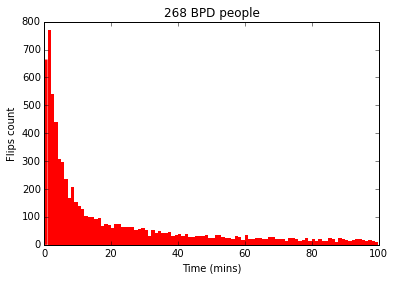

Average size of total tweets: 939.5671641791045 std:
Time Duration mean:20.470854 STD:24.799939


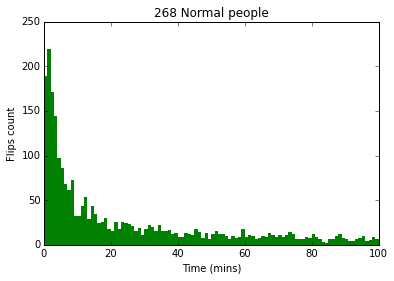

Average size of total tweets: 1239.0298507462687 std:
Time Duration mean:23.635658 STD:26.655363


In [8]:
#The X-axis is the time of one flip, the Y-axis is the flips count
flipDurationPlot(groups)

/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/usr/local/lib/python3.4/dist-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Flip Durations of each person


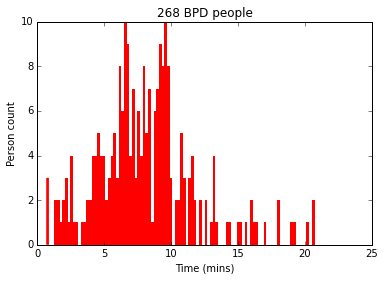

Time Duration mean:8.097105 STD:3.729885


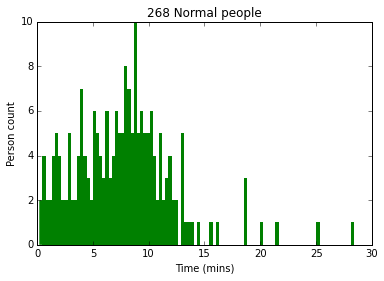

Time Duration mean:7.637910 STD:4.415309


In [9]:
#The X-axis is the average flip time of user , the Y-axis is the user count
flipDurationPlotPerUser(groups, upperbound=30)

/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


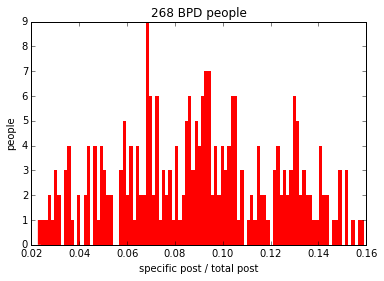

Average size of total tweets: 939.5671641791045 std:
 Mean:0.089687 STD:0.033085


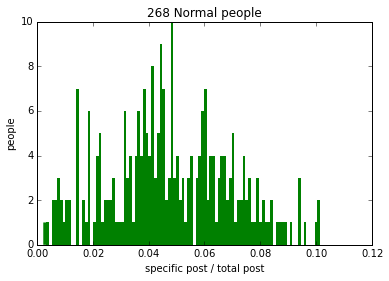

Average size of total tweets: 1239.0298507462687 std:
 Mean:0.047396 STD:0.021910


In [10]:
#The X-axis is the flips/all-tweets ratio, the Y-axis is users count
countPlotPerUser(groups, getFlips, method=None)

/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


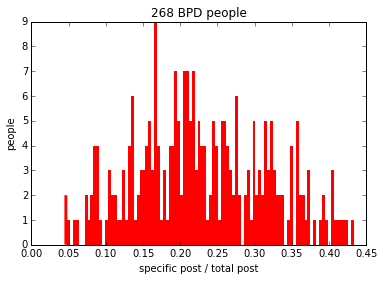

Average size of total tweets: 939.5671641791045 std:
 Mean:0.229136 STD:0.088661


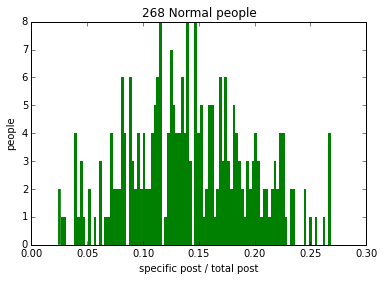

Average size of total tweets: 1239.0298507462687 std:
 Mean:0.142275 STD:0.054339


In [11]:
#The X-axis is the negative-post/all-tweets ratio, the Y-axis is users count
countPlotPerUser(groups, negative_counter, method=None)

/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


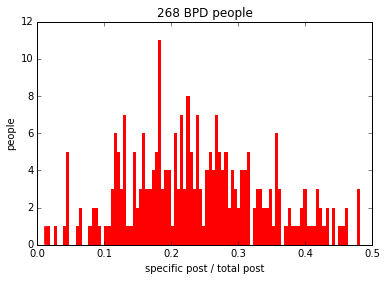

Average size of total tweets: 939.5671641791045 std:
 Mean:0.239518 STD:0.102617


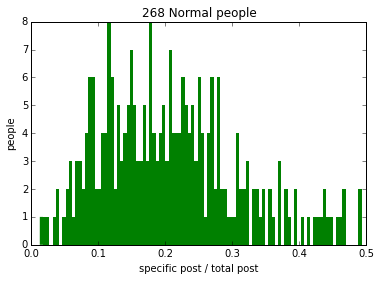

Average size of total tweets: 1239.0298507462687 std:
 Mean:0.206541 STD:0.103112


In [12]:
#The X-axis is the positive-post/all-tweets ratio, the Y-axis is users count

countPlotPerUser(groups, positive_counter, method=None)

/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


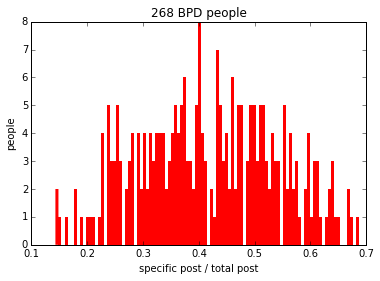

Average size of total tweets: 939.5671641791045 std:
 Mean:0.417319 STD:0.123112


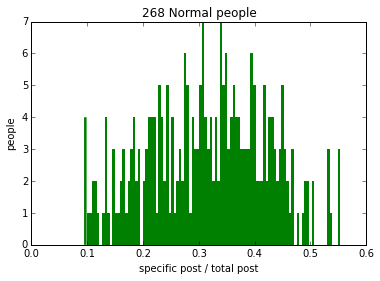

Average size of total tweets: 1239.0298507462687 std:
 Mean:0.314910 STD:0.107018


In [13]:
#The X-axis is the first-pronoun/all-tweets ratio, the Y-axis is users count

countPlotPerUser(groups, seriesContains) #First-pronoun

/usr/local/lib/python3.4/dist-packages/pandas/core/indexing.py:415: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


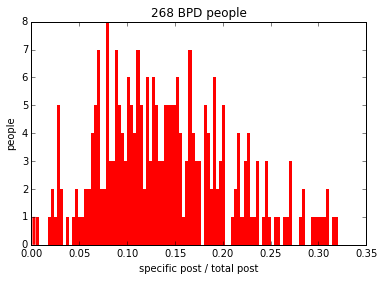

Average size of total tweets: 939.5671641791045 std:
 Mean:0.141822 STD:0.068745


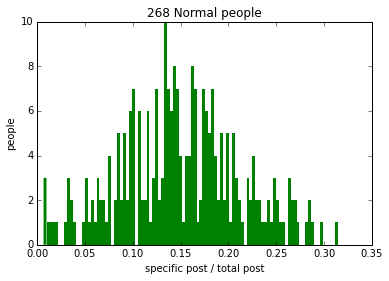

Average size of total tweets: 1239.0298507462687 std:
 Mean:0.149611 STD:0.063076


In [ ]:
#The X-axis is the second-pronoun/all-tweets ratio, the Y-axis is users count

countPlotPerUser(groups, seriesContains, method="second") #second-pronoun

In [ ]:
#The X-axis is the third-pronoun/all-tweets ratio, the Y-axis is users count

countPlotPerUser(groups, seriesContains, method = "third") #Third-pronoun

In [ ]:
#The X-axis is the amount of negative combos, the Y-axis is combo counts

comboPlot(groups, upperbound=15, lowerbound=2, bins = 20)

In [ ]:
#The 》-axis is the amount of positive combos, the Y-axis is combo counts

comboPlot(groups, upperbound=15, lowerbound=2, bins = 20, element_value=1)

In [ ]:
#The X-axis is the ration of 3-or-higher negative-combo/all-tweets, the Y-axis is the user count 
comboPlotPerUser(groups,lowerbound=2,  upperbound=np.inf)   #   negative文章連發三次以上,    連發次數除以全部發文數

In [ ]:
3